## Bayesian AGN Decomposition Analysis for SDSS Spectra (BADASS)
### Single Spectrum

####  Remington O. Sexton$^{1,2}$, Sara M. Doan$^{1}$, Michael A. Reefe$^{1}$, William Matzko$^{1}$
$^{1}$George Mason University, $^{2}$United States Naval Observatory


In [1]:
import glob
import time
import natsort
from IPython.display import clear_output
# import multiprocess as mp
import os
import psutil
import pathlib
import natsort
# Import BADASS here
import badass as badass
import badass_utils as badass_utils
import badass_ncomp_options

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### BADASS Options

In [2]:
options_file = "badass_ncomp_options.py"
if os.path.exists(options_file):
    print("\n Options file %s found.\n" % (options_file))


 Options file badass_ncomp_options.py found.



### Run BADASS on a single spectrum

The following is shows how to fit single SDSS spectra.

#### Directory Structure

In [3]:
nobj = 2 # Object in the spec_dir list
########################## Directory Structure #################################
spec_dir = 'examples/' # folder with spectra in it
# Get full list of spectrum folders; these will be the working directories
spec_loc = natsort.natsorted( glob.glob(spec_dir+'*') )[nobj]

################################################################################
print(len(spec_loc))
print(spec_loc)


15
examples/2-test


#### Choose Spectrum 

In [4]:
file = glob.glob(spec_loc+'/*.fits')[0] # Get name of FITS spectra file
print(file)

examples/2-test/spec-2756-54508-0579.fits


#### Run IRSA Dust Query
To correct for Galactic extinction.  This only needs to be done once so that the data is stored locally.

In [5]:
# badass_utils.fetch_IRSA_dust(spec_loc)

#### Run 

Start process memory: 0.59401830                    
 Storing MCMC_output in examples/2-test/MCMC_output_5/

 > Starting fit for 2-test

 Input fitting region exceeds available wavelength range.  BADASS will adjust your fitting range automatically...
		- Input fitting range: (4400, 5500)
		- Available wavelength range: (2218, 5354)
		- New fitting region is (4400, 5355). 



-----------------------------------------------------------
 file:                        spec-2756-54508-0579.fits     
 SDSS redshift:               0.71967                       
 fitting region:              (4400,5355) [A]               
 velocity scale:              69.15 [km/s/pixel]            
 Galactic E(B-V):             0.032                         
 Flux Normalization:          1.0e-17                       
-----------------------------------------------------------
	 - Adding parameter for unexplained noise to fit reduced Chi-squared.
	 - Fitting a SSP host-galaxy template.
  - Fitting additive lege

SystemExit: 0

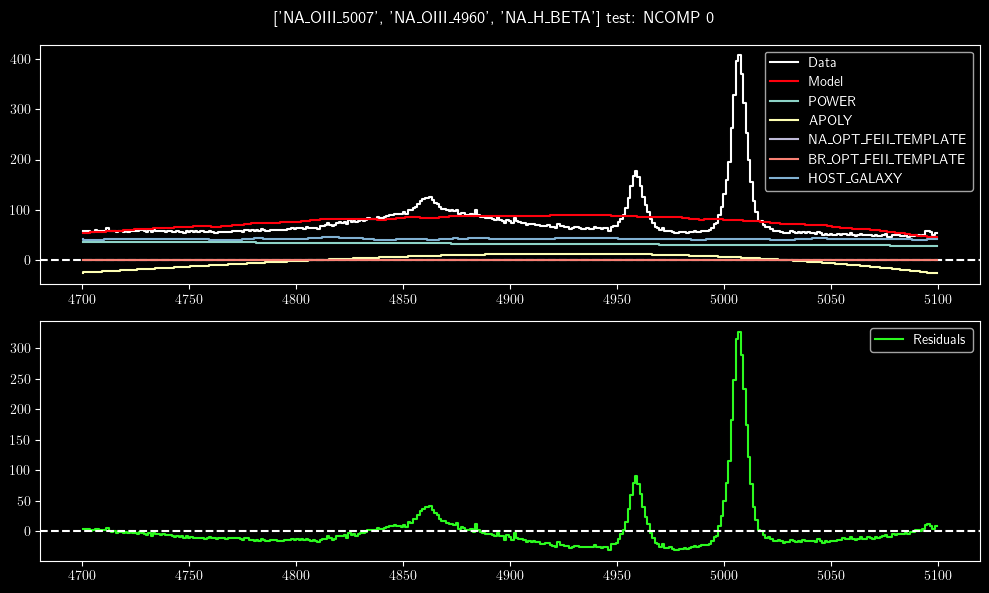

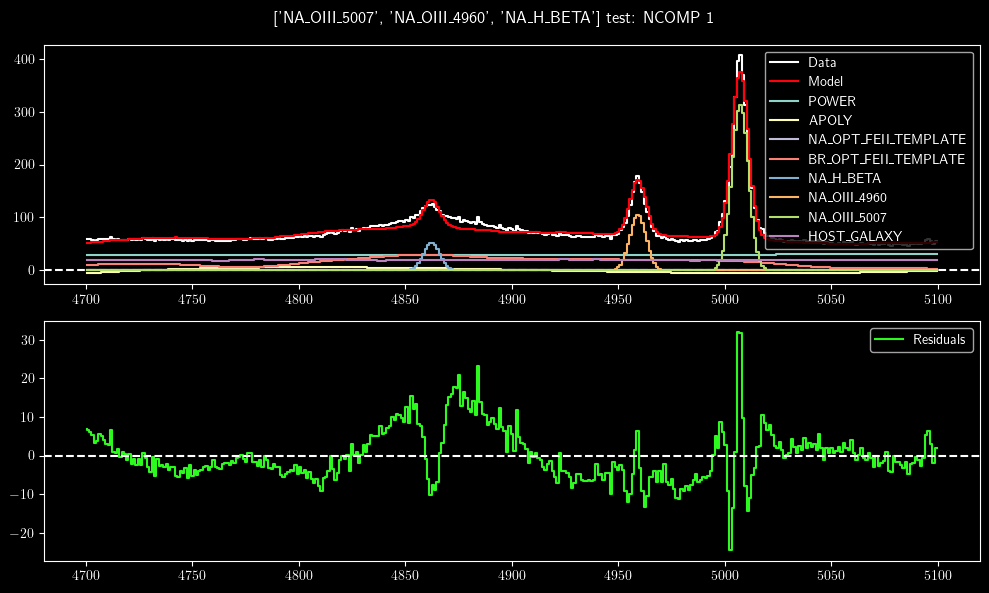

In [8]:
import importlib
importlib.reload(badass)
importlib.reload(badass_utils)
importlib.reload(badass_ncomp_options)



# Call the main function in BADASS
badass.run_BADASS(pathlib.Path(file),
                  options_file = options_file,
                 )
    #